In [3]:
import sys
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
sys.path.append('/home/ardelalegre/SoundMapping/Database')
from DatabaseAPI import DatabaseAPI
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from get_time_interval_data import *
from PCA import *
from Plot import *
import pickle
# from sklearn.cluster import KMeans

In [2]:
# clean out NaNs and zeros
def extract_all_active_observations(interval_matrix_data, array_indices):
    # exclude time column
    observations = interval_matrix_data[:,1:]
    selected_obs = np.hstack([observations[:,i*3:i*3+3] for i in array_indices])
    cleaned_data = []
    ind = []
    for i in range(selected_obs.shape[0]):
        if not any(np.isnan(selected_obs[i,:])) and not any(selected_obs[i,:]==0):
            cleaned_data.append(selected_obs[i,:])
            ind.append(i)
    selected_raw_obs = interval_matrix_data[ind,:]        
    return  np.vstack(cleaned_data), selected_raw_obs

In [11]:
def plot_time_series(time_interval_matrix_data, arrays_to_disp):
    data = time_interval_matrix_data
    length = data.shape[0]
    num_array = len(arrays_to_disp)
    fig = plt.figure(figsize = [20,12])
    for i in range(0,num_array):
        ax = fig.add_subplot(num_array,1,i+1)
        array_label = 'array {}'.format(arrays_to_disp[i])
        ax.plot(data[:,arrays_to_disp[i]*3+1], label=array_label+' X')
        ax.plot(data[:,arrays_to_disp[i]*3+2], label=array_label+' Y')
        ax.plot(data[:,arrays_to_disp[i]*3+3], label=array_label+' Z') 
        ax.set_xlim(0,length)
        ax.set_ylim(-1,1)
        ax.legend()
    plt.show()

## note
Different from previous static point experiments, two arrays are mounted onto the wall: array 0 and 1, and array 2, 3, 5 are mounted to the ceiling. 

## Desk Static Point Experiment

In [4]:
# the first 5 points
desk_spe = get_time_interval_matrix_data("Jan 02 2021 02:10PM", "Jan 02 2021 02:15PM")

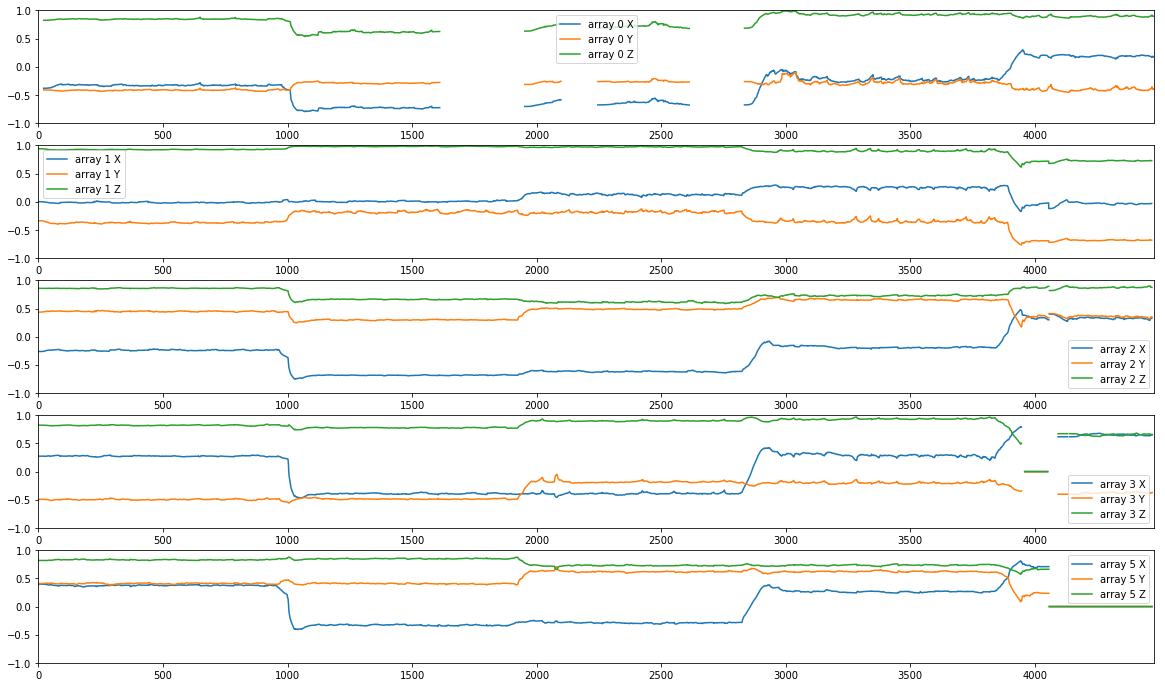

In [15]:
plot_time_series(desk_spe, [0,1,2,3,5])

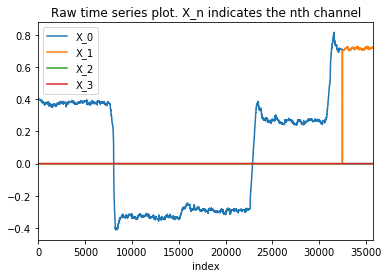

In [6]:
plot_raw_time_series("Jan 02 2021 02:10PM", "Jan 02 2021 02:15PM",5)

stitching array 5

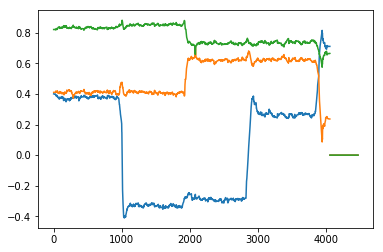

In [7]:
# array 5
array_5_x = desk_spe[:,16]
array_5_y = desk_spe[:,17]
array_5_z = desk_spe[:,18]

# doing np.where == 0
array_5_x_0_indices = np.where(array_5_x==0)
array_5_y_0_indices = np.where(array_5_y==0)
array_5_z_0_indices = np.where(array_5_z==0)

# importing missing data from pickle
array_5_x_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/array_5_x_missing_data.p', 'rb'))
array_5_y_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/array_5_y_missing_data.p', 'rb'))
array_5_z_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/array_5_z_missing_data.p', 'rb'))

# plotting before stitching
plt.plot(array_5_x)
plt.plot(array_5_y)
plt.plot(array_5_z);

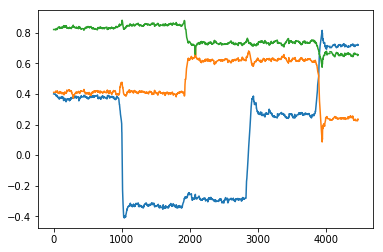

In [8]:
# padding before stitching
# array_5_x_md_padded = np.pad(array_5_x_md, 1, mode = 'symmetric')

# figuring out the array to stitch back
array_5_x[array_5_x_0_indices] = array_5_x_md[:-1] # _padded
array_5_y[array_5_y_0_indices] = array_5_y_md[:-1]
array_5_z[array_5_z_0_indices] = array_5_z_md[:-1]

# stitching
desk_spe[:,16] = array_5_x
desk_spe[:,17] = array_5_y
desk_spe[:,18] = array_5_z

# after stitching
plt.plot(array_5_x)
plt.plot(array_5_y)
plt.plot(array_5_z);

In [9]:
# last point
last_point = get_time_interval_matrix_data("Jan 02 2021 02:15PM", "Jan 02 2021 02:16PM")
desk_spe = np.vstack([desk_spe, last_point])

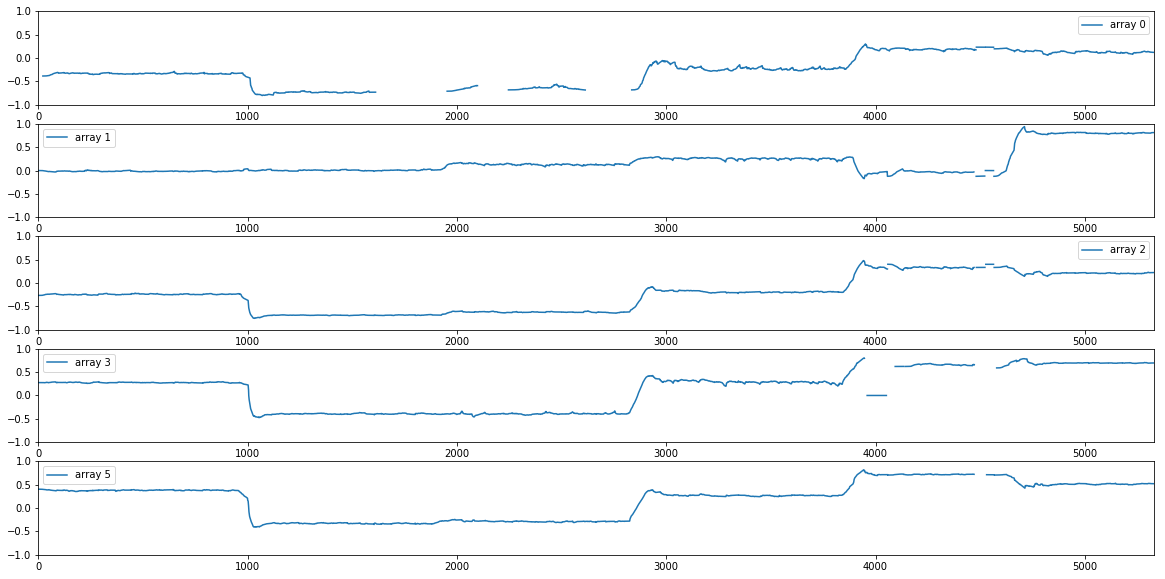

In [10]:
plot_time_series(desk_spe)

In [11]:
point1 = desk_spe[:950,:]
point2 = desk_spe[1100:1900,:]
point3 = desk_spe[2000:2700,:]
point4 = desk_spe[3000:3750,:]
point5 = desk_spe[4100:4600,:]
point6 = desk_spe[4900:,:]

In [30]:
# point1, _ = extract_all_active_observations(point1, [0,1,2,3,5])
# point2, _ = extract_all_active_observations(point2, [0,1,2,3,5])
# point3, _ = extract_all_active_observations(point3, [0,1,2,3,5])
# point4, _ = extract_all_active_observations(point4, [0,1,2,3,5])
# point5, _ = extract_all_active_observations(point5, [0,1,2,3,5])
# point6, _ = extract_all_active_observations(point6, [0,1,2,3,5])

In [31]:
# points = [point1, point2, point3, point4, point5, point6]
# pickle.dump(points,open('points.p','wb'))

In [12]:
_, desk_spe_cleaned = extract_all_active_observations(np.vstack([point1, point2, point3, point4, point5, point6]),
                                                      [0,1,2,3,5])

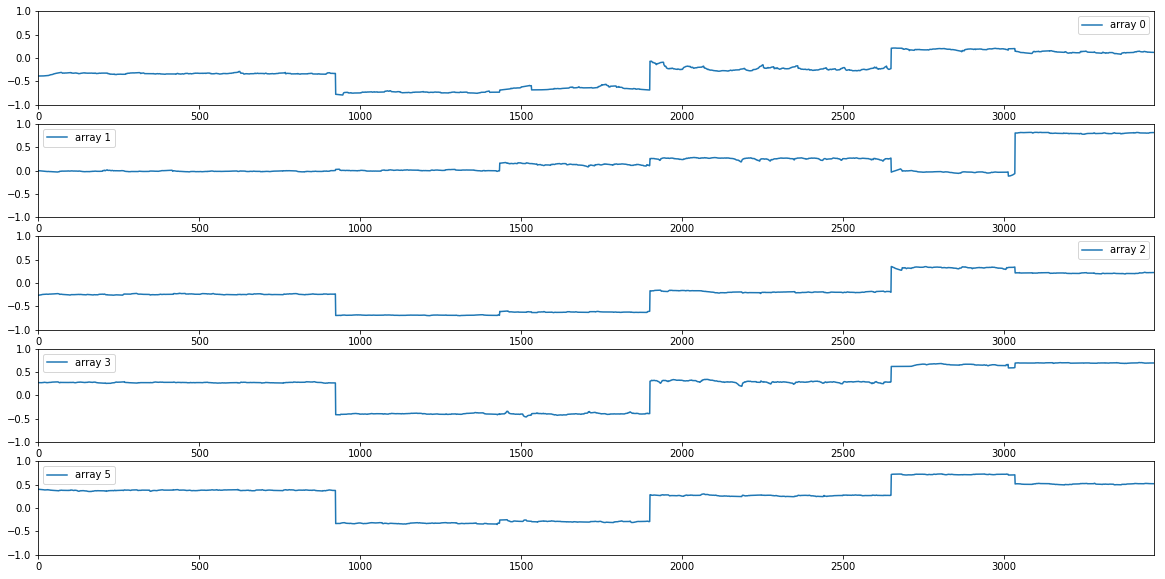

In [13]:
plot_time_series(desk_spe_cleaned)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:43: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


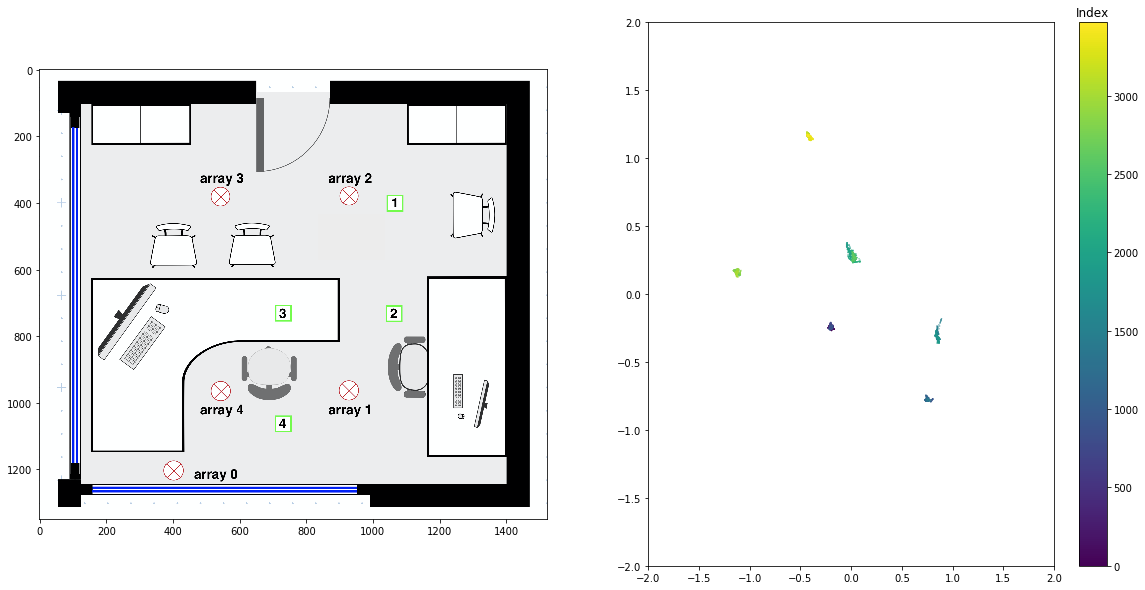

In [14]:
desk_spe_cdata = get_cdata(desk_spe_cleaned)
desk_spe_projections = project_to_eigen_vectors(desk_spe_cdata, 2, EIGEN_VALUES_0101, EIGEN_VECTORS_0101)

fig = plt.figure(figsize = [20,10])

ax2 = fig.add_subplot(121)
room_model_chair = plt.imread('../room_model_v4.png')
ax2.imshow(room_model_chair)

ax = fig.add_subplot(122)
temp = ax.scatter(desk_spe_projections[:,0], 
                  desk_spe_projections[:,1], 
                  c = np.arange(desk_spe_projections.shape[0]), 
                  s=0.1)

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
cbar = fig.colorbar(temp, ax=ax)
cbar.ax.set_title('Index')

plt.show()

## Desk Rectangular Slide

In [15]:
# "Jan 02 2021 03:00PM", "Jan 02 2021 03:02PM"
# "Jan 02 2021 03:03PM", "Jan 02 2021 03:05PM"
rec_slide = get_time_interval_matrix_data("Jan 02 2021 03:03PM", "Jan 02 2021 03:05PM")

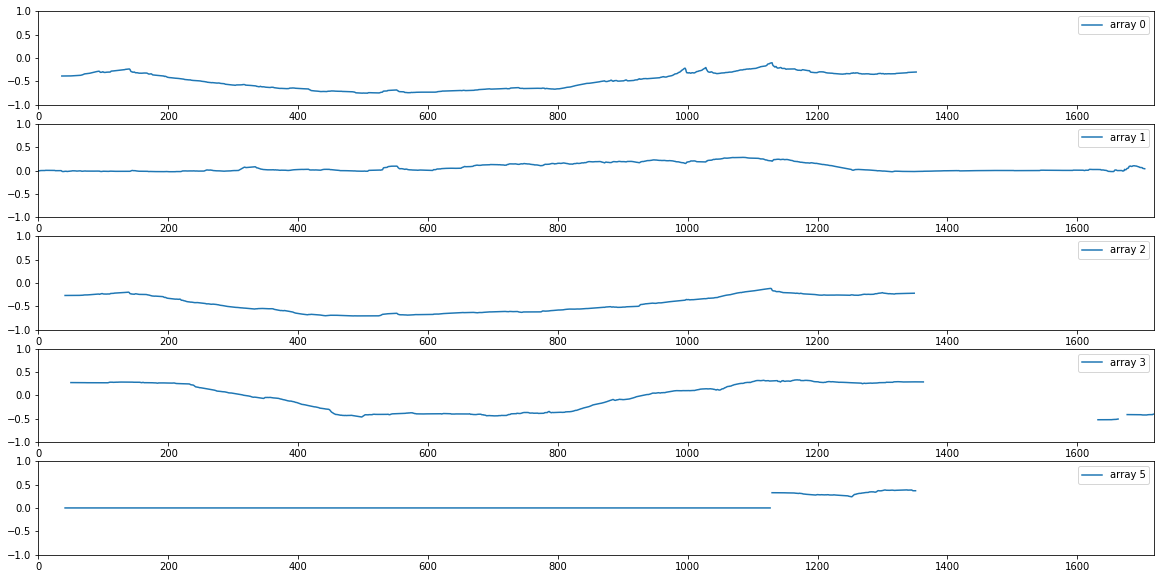

In [16]:
plot_time_series(rec_slide)

Stitching array 5

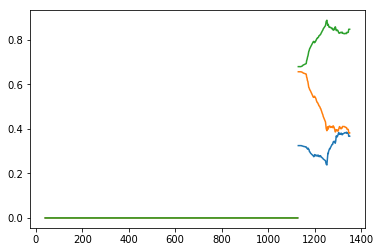

In [17]:
# array 5
array_5_x = rec_slide[:,16]
array_5_y = rec_slide[:,17]
array_5_z = rec_slide[:,18]

# doing np.where == 0
array_5_x_0_indices = np.where(array_5_x==0)
array_5_y_0_indices = np.where(array_5_y==0)
array_5_z_0_indices = np.where(array_5_z==0)

# importing missing data from pickle
array_5_x_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/rec_array_5_x_missing_data.p', 'rb'))
array_5_y_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/rec_array_5_y_missing_data.p', 'rb'))
array_5_z_md = pickle.load(open('/home/ardelalegre/Documents/SoundMapping/Analysis/notebooks/rec_array_5_z_missing_data.p', 'rb'))

# plotting before stitching
plt.plot(array_5_x)
plt.plot(array_5_y)
plt.plot(array_5_z);

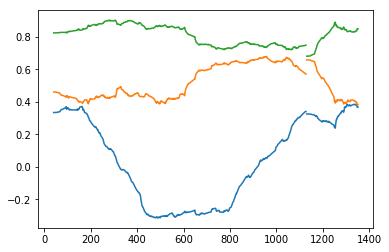

In [18]:
# padding before stitching
# array_5_x_md_padded = np.pad(array_5_x_md, 1, mode = 'symmetric')

# figuring out the array to stitch back
array_5_x[array_5_x_0_indices] = array_5_x_md # _padded
array_5_y[array_5_y_0_indices] = array_5_y_md
array_5_z[array_5_z_0_indices] = array_5_z_md

# stitching
rec_slide[:,16] = array_5_x
rec_slide[:,17] = array_5_y
rec_slide[:,18] = array_5_z

# after stitching
plt.plot(array_5_x)
plt.plot(array_5_y)
plt.plot(array_5_z);

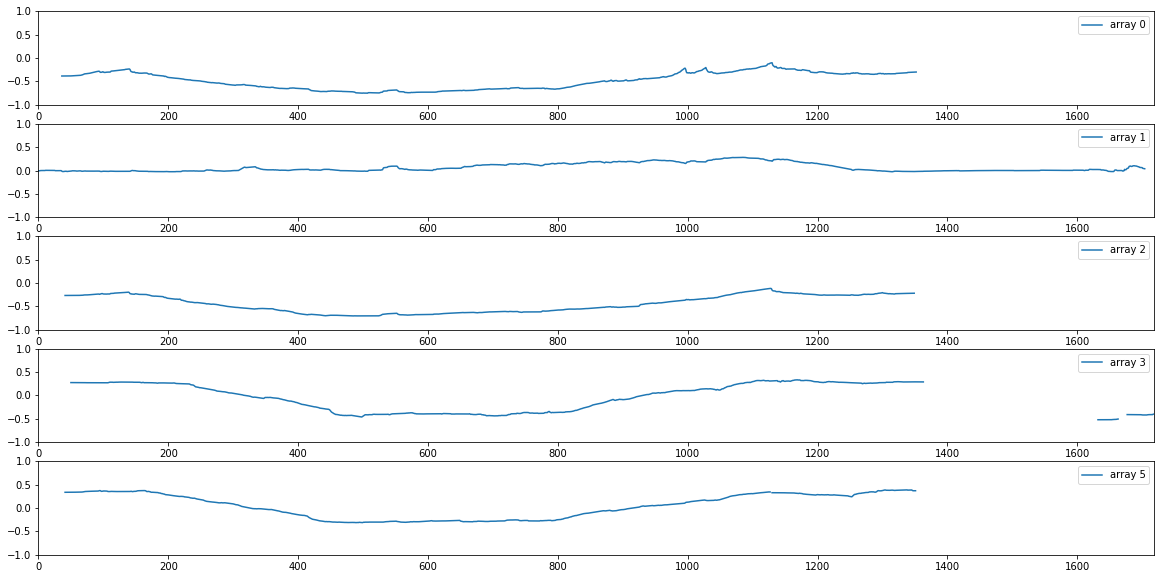

In [19]:
plot_time_series(rec_slide)

In [20]:
_, rec_slide_cleaned = extract_all_active_observations(rec_slide, [0,1,2,3,5])

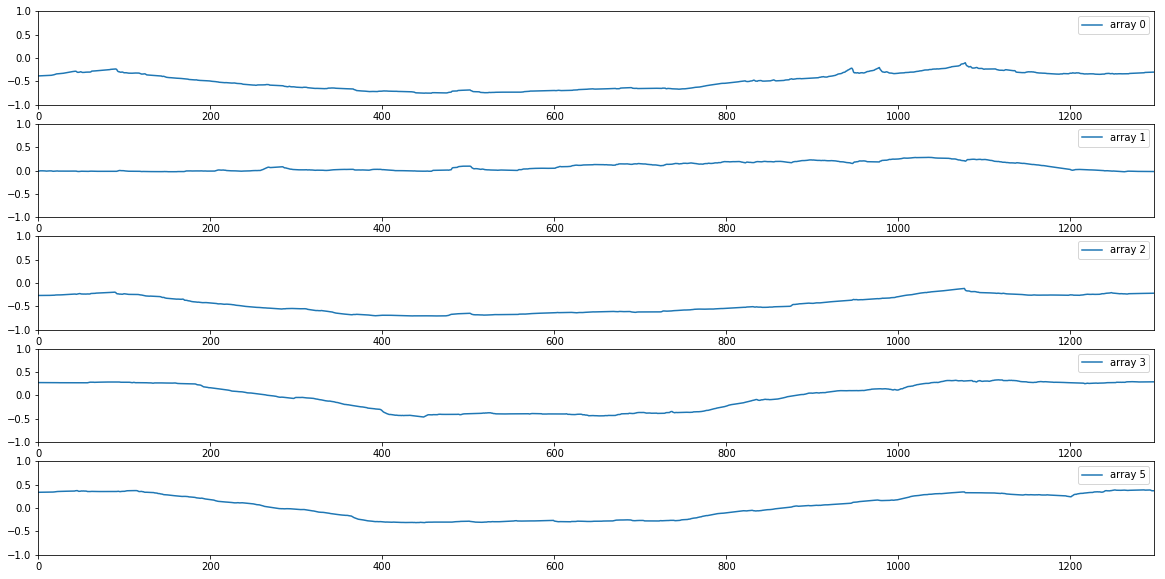

In [21]:
plot_time_series(rec_slide_cleaned)

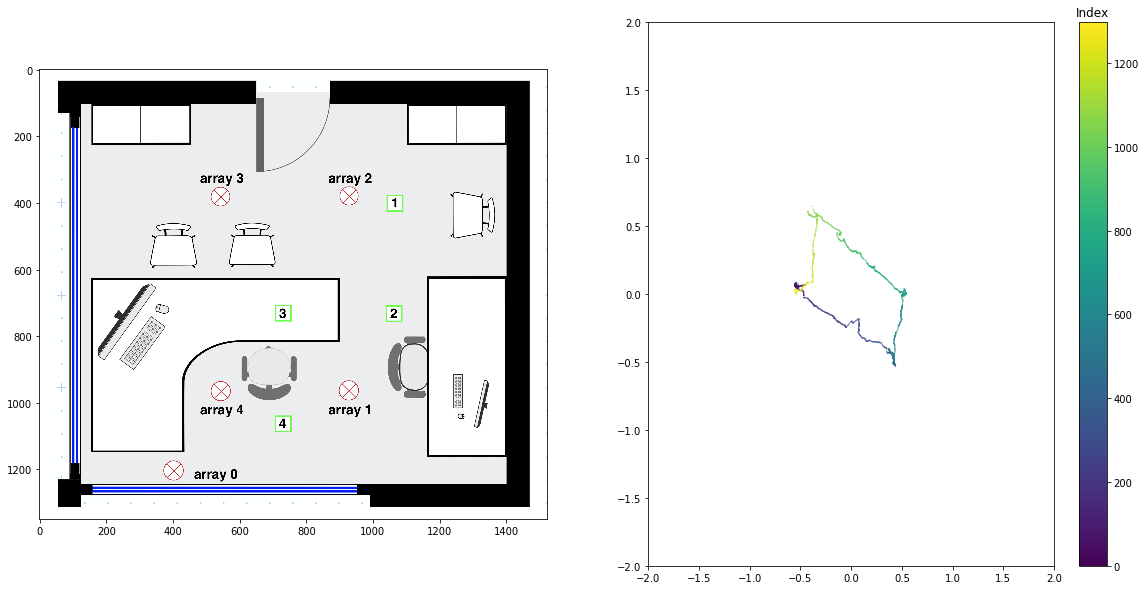

In [22]:
rec_slide_cdata = get_cdata(rec_slide_cleaned)
rec_slide_projections = project_to_eigen_vectors(rec_slide_cdata, 2, EIGEN_VALUES_0101, EIGEN_VECTORS_0101)

fig = plt.figure(figsize = [20,10])

ax2 = fig.add_subplot(121)
room_model_chair = plt.imread('../room_model_v4.png')
ax2.imshow(room_model_chair)

ax = fig.add_subplot(122)
temp = ax.scatter(rec_slide_projections[:,0], 
                  rec_slide_projections[:,1], 
                  c = np.arange(rec_slide_projections.shape[0]), 
                  s=0.1)

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
cbar = fig.colorbar(temp, ax=ax)
cbar.ax.set_title('Index')

plt.show()

## Desk Straight Line Slide

In [23]:
# "Jan 02 2021 02:53PM", "Jan 02 2021 02:53PM"
# "Jan 02 2021 03:02PM", "Jan 02 2021 03:03PM"
# "Jan 02 2021 03:05PM", "Jan 02 2021 03:06PM"
line_slide = get_time_interval_matrix_data("Jan 02 2021 03:05PM", "Jan 02 2021 03:06PM")

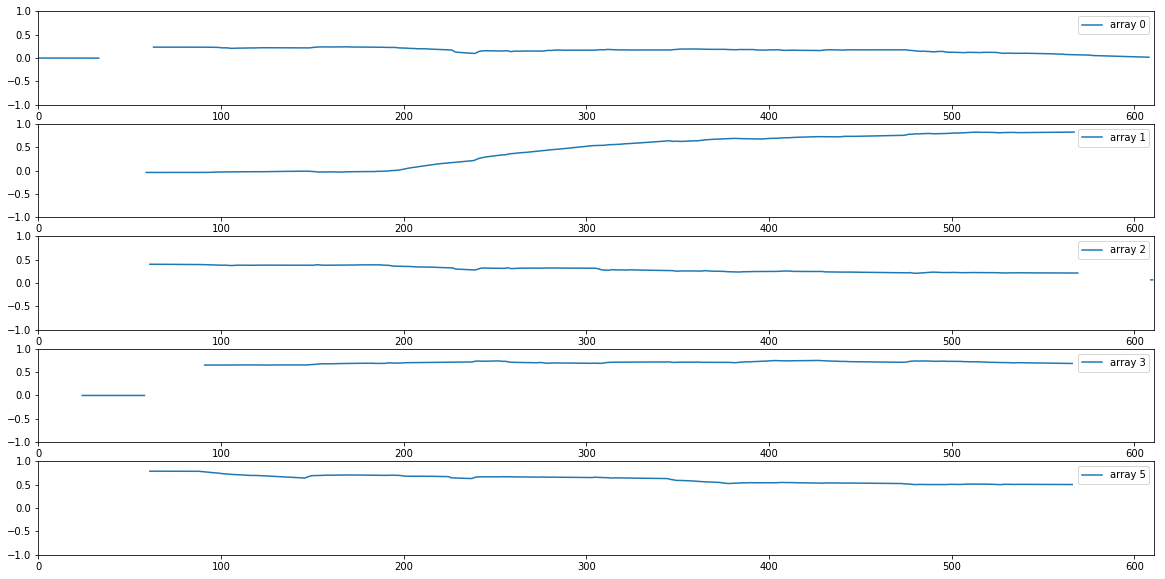

In [24]:
plot_time_series(line_slide)

In [25]:
_, line_slide_cleaned = extract_all_active_observations(line_slide, [0,1,2,3,5])

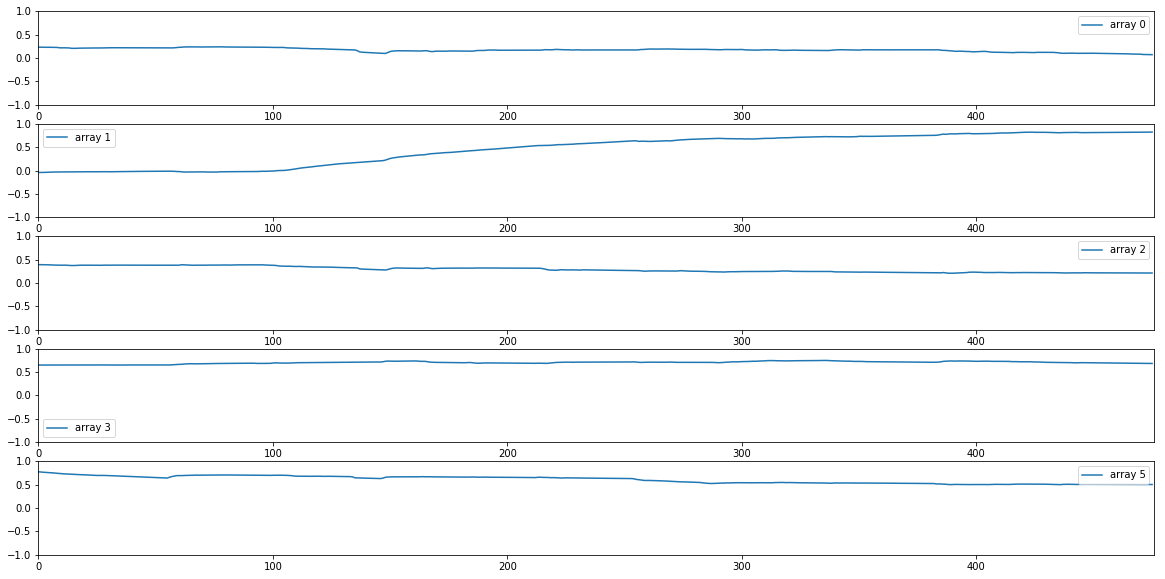

In [26]:
plot_time_series(line_slide_cleaned)

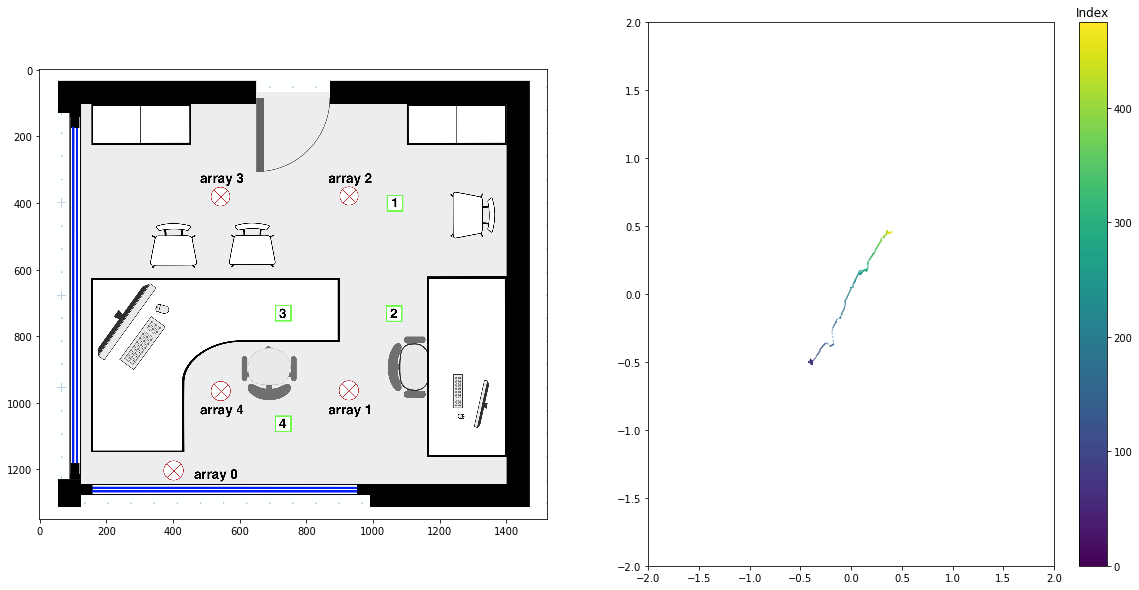

In [27]:
line_slide_cdata = get_cdata(line_slide_cleaned)
line_slide_projections = project_to_eigen_vectors(line_slide_cdata, 2, EIGEN_VALUES_0101, EIGEN_VECTORS_0101)

fig = plt.figure(figsize = [20,10])

ax2 = fig.add_subplot(121)
room_model_chair = plt.imread('../room_model_v4.png')
ax2.imshow(room_model_chair)

ax = fig.add_subplot(122)
temp = ax.scatter(line_slide_projections[:,0], 
                  line_slide_projections[:,1], 
                  c = np.arange(line_slide_projections.shape[0]), 
                  s=0.1)

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
cbar = fig.colorbar(temp, ax=ax)
cbar.ax.set_title('Index')

plt.show()

In [28]:
# pickle.dump(desk_spe_cleaned, open("desk_spe_cleaned.p", "wb"))
# pickle.dump(rec_slide_cleaned, open("rec_slide_cleaned.p", "wb"))
# pickle.dump(line_slide_cleaned, open("line_slide_cleaned.p", "wb"))